# Data Visualisation - Lab 8 - Cellular Automata

---

**Authors: Claire Rocks and Saif Anwar**

---

A cellular automaton (CA) is a collection of cells arranged in a grid.  Each cell changes state as a function of time, according to a defined set of rules driven by the states of neighbouring cells.  CAs have been suggested for possible use in modelling geography, anthropology, political science, sociology and physics, among others.

## Elementary CAs

There are many types of CA. The simplest type is a binary, nearest-neighbour, one-dimensional automaton called elementary cellular automata.  It is one-dimensional.  Cells can have only one of two possible values: 0 or 1. The state a cell will have in the next generation is based on the value of:
* the cell to its left
* the cell itself
* the cell to its right

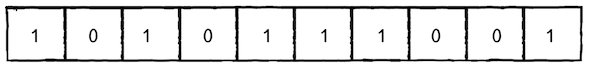

Given a starting state (Generation 0), how do we compute the states for all cells at generation 1? And generation 2? And so on?

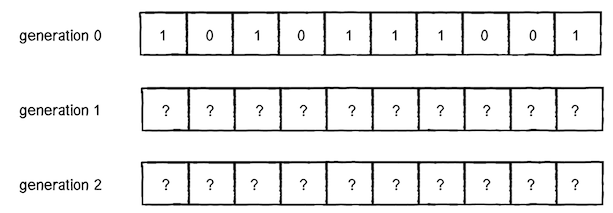

We calculate a new state value by looking at all the previous neighbour states.

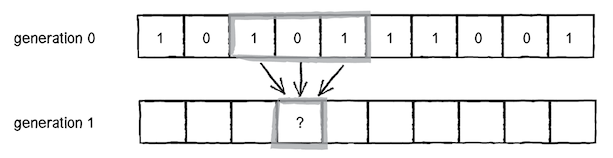

We can define an outcome (new state value: 0 or 1) for each of the possible configurations of the 3 cells (the cell to the left, the cell itself, the cell to the right) – this is known as the rule set e.g.

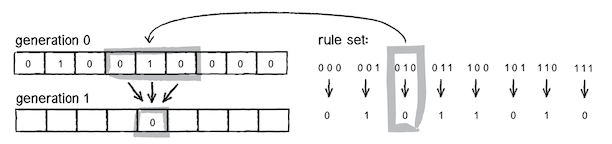

We can visualise the output on a grid

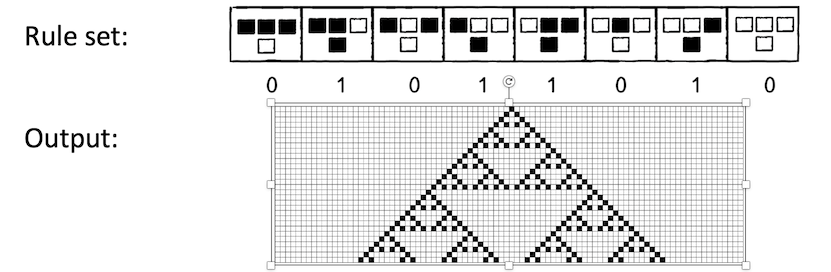

## Moving to 2 dimensions

This will introduce some additional complexity - each cell will have a bigger neighbourhood, but that will open up the door to a range of possible applications.

There are 5 common cellular automata neighbourhoods: (a) Empty, (b) Von Neumann, (c) Moore, (d) MvonN, (e) Extended. 

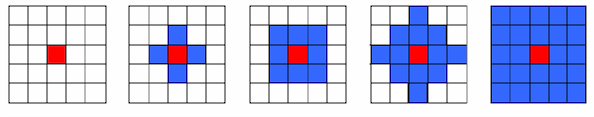

With nine cells, there are 512 possible combinations of cells (neighbourhoods). In most cases, it would be impractical to define an outcome for every single possibility as we did in the elementary cellular automata

Instead we can define a set of rules according to general characteristics of the neighbourhood.  We can see this through a very famous cellular automaton devised by the British mathematician John Conway in 1970, The Game of Life.

The game is usually played on a 2-dimensional grid. Cells are either alive (black) or dead (white). After an initial pattern is set, subsequent generations are created by applying a set of rules to each cell and its surrounding 8 neighbours (Moore neighbourhood):

* Any live cell with fewer than two live neighbours dies - loneliness
* Any live cell with more than three live neighbours dies - overcrowding
* Any dead cell with exactly three live neighbours becomes a live cell - reproduction

To calculate the cell state in the next generation we need to:

1. Take a look at the neighbourhood states: The 8 surrounding cells.
2. Look up the new value for the cell state according to the ruleset.
3. Set the cell’s state to that new value.

The CA itself is in two dimensions. We could try creating an elaborate 3D visualization of the results and stack all the generations in a cube structure. However, the typical way the Game of Life is displayed is to treat each generation as a single frame in an animation.

The rules of a CA don’t necessarily have to define an exact outcome.  For example, we could rewrite the Game of Life rules as follows:

* A live cell with < 2 live neighbours dies with the probability of 90%
* A live cell with >3 live neighbours dies with the probability of 92%
* A live cell with 2 or 3 live neighbours stays alive
* A dead cell with exactly 3 live neighbours comes alive with the probability of 95%

This is a probabilistic Cellular Automata

In this lab, we are going to work through an example of a probabilistic Cellular Automata that models a SIR model.

SIR model has 3 possible states: *S*usceptible individuals can become *I*nfected if they are in close contact to infected people i.e. a neighbour is infected.  After a while an infected individual will *R*ecover.  We are going to assume that each timestep/generation = 1 week 


## Setup for the Lab

In this lab we need to use several python packages, so our first job is to import some libraries to help us out:

*   numpy - allows for advanced maths functions
*   matplotlib - helps us draw plots
*   random - used to generate randon numbers
*   math - provides access to the mathematical functions
*   pandas - helps with data analysis and manipulation to display summary statistics
*   seaborn - data visualization library based on matplotlib


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import math
import matplotlib.patches as mpatches

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns


The next job is to set up a grid of cells (in this case 50*50), with a single infected individual and a simulation of 80 steps.

In [2]:
# number of rows and columns in each grid
col = 50
row = 50

# initial number of infected cells
infected = 1

# number of steps in simulation
num_steps = 80

# global 3D array to store grid at each timestep
state = np.array([[[0] * row] * col] * num_steps)

Next we initialise the grid

*   Setting all cell values to 0 (susceptible)
*   Pick num_infected random cell(s) and set to 1 (infected)

In [3]:
# function to set the initial state
def initialise_state():

    # (susceptible = 0, infected = 1, recovered = 2)

    # Set everything to zero - susceptible
    cells = [[0 for i in range(row)] for j in range(col)]

    # pick random infected cell(s), set = 1
    for x in range(0, infected) :
      cells[random.randint(0, row-1)][random.randint(0, col-1)] = 1
    return cells


In order to update the state, we need a function that will count the number of infected neighbours.  The function requires a grid and an i, j index for the cell we want to count the neighbours of.

In [4]:
# for cell i, j in grid count the number of infected neighbouring cells (moore neighbourhood)
def count_infected_neighbours(grid, i, j):
    count = 0
    for x, y in (
            (i - 1, j), (i + 1, j), (i, j - 1),
            (i, j + 1), (i - 1, j - 1), (i - 1, j + 1),
            (i + 1, j - 1), (i + 1, j + 1)):
        if not (0 <= x < len(grid) and 0 <= y < len(grid[x])):
            # out of bounds
            continue
        # check if the neighbour is infected (state = 1), if so add to count
        if grid[x][y] == 1:
            count += 1
    return count

Now we know the number of infected neighbours, we can use a simple logistic function to compute the probability of being infected as a function of the number of infected neighbours

$P_{infect} = \frac{1}{1 + e^{−(a+bx)}}$

where a = -1.5, b = 0.6 and x = the number of infected neighbours

Using this function, and defining the probability that an infected individual recovers $P_{recover} = 0.5$ each week (we expect that half the infected individuals will recover in each timestep and that most infected individuals will stay infected for 1-3 weeks), we are now able to update the state, creating a new grid (the next generation).  

*   The first thing we do is copy the previous grid
*   Next we set the empirical values for our probability function
*   Then we iterate over each cell in the array, and
> 1. count the number of infected neighbours
> 2. calculate the probability of infection
> 3. generate a random number to compare with the probability of infection
> 4. Check if the cell is susceptible (state=0), and if it is compare the probability of infection to the random number.  If the value of the random number is < probability of infection we change the value of the cell in the new array to infected (state=1)
> 5. Check if the cell is infected (state=1), and if it is, we compare the value of the random number to the probability of recovery.  If the value of the random number is < probability of recovery,  we change the value of the cell in the new array to recovered (state=2)
> 6. Otherwise, the cell value in the new array (this generation) remains the same as the value in the previous array (previous generation)

In [5]:
def update_state(previous_array):

    # copy previous array
    new_array = np.copy(previous_array)

    # set the empirical values for our probability function
    a = -1.5
    b = 0.6

    # for each cell in new array
    for i in range(row):
      for j in range(col):

          # count number of neighbours
          num_inf_neighbours = count_infected_neighbours(previous_array, i, j)

          # calculate probability of infection - p=1/(1+exp(-(-a+b*number of infected neighbours)))
          prob_infection = 1/(1+math.exp(-(a+b*num_inf_neighbours)))

          # generate a random number
          rand = random.random()

          # if susceptible, count number of infected neighbours to see if catch infection,
          if (previous_array[i][j] == 0 and rand < prob_infection):
             new_array[i][j] = 1

          # if infected check whether can set to recovered, p = 0.5
          if (previous_array[i][j] == 1 and rand < 0.5):
            new_array[i][j] = 2

    return new_array

Now we can run the simulation.  We first create the initial state (generation 0), then call update state to create a new array for each generation, creating num_steps generations in total.

In [6]:
def run_simulation():

    state[0]= initialise_state()

    for t in range(1, num_steps):
        state[t] = update_state(state[t-1])
    return

run_simulation()

This next bit of code lets us visualise a grid

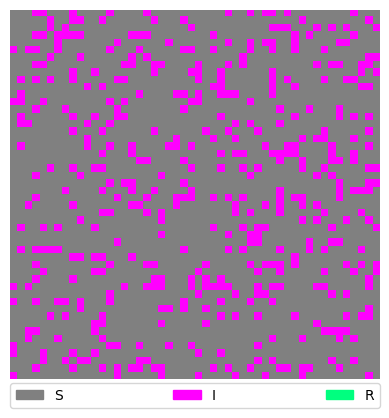

In [7]:

# mapping colours to (susceptible = 0, infected = 1, recovered = 2)
cmap = mpl.colors.ListedColormap(['gray','magenta','springgreen'])

# function to generate visual grid
def array_plot(array):
    ax.imshow(
    array,
    cmap = cmap,
    vmin=0, vmax=2
    )
    g_patch = mpatches.Patch(color='gray', label= 'S')
    m_patch = mpatches.Patch(color='magenta', label= 'I')
    s_patch = mpatches.Patch(color='springgreen', label= 'R')
    ax.legend(handles=[g_patch, m_patch, s_patch], bbox_to_anchor=(0, -0.01, 1, 0), mode="expand" , ncol=3, borderaxespad=0)
    return

fig, ax = plt.subplots()
ax.axis("off")
array_plot(state[1])

This next bit of code, joins each of the grid visualisations together in an animation

In [8]:
def animate(i):

    array_plot(state[i])

    return

# Create an animation object which:
# - animate the Figure, `fig`array_plot(state[i])
# - using the function `animate`
# - for len(state) number of frames
# - where each frame lasts 100 milliseconds
anim = FuncAnimation(fig, animate, frames=len(state), interval=100)

# Display the animation in the notebook
HTML(anim.to_jshtml())

This final bit of code creates a plot of the summary statistics.  for each generation it:

*   Counts the number of susceptible, infected and recovered cells
*   Adds the counts to a pandas dataframe
*   uses the seaborn library to create a line graph of the values at each generation






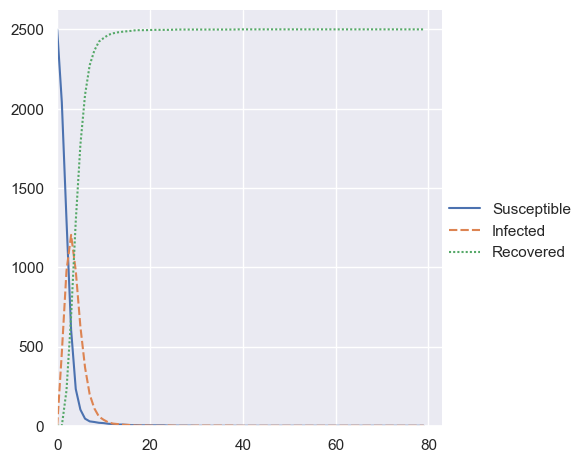

In [9]:
# Summary data
# functions to count the number of susceptible, infected and recovered cells
def count_susceptible(grid):
  count = 0
  for i in range(row):
      for j in range(col):
          if grid[i][j] == 0:
            count +=1
  return count

def count_infected(grid):
  count = 0
  for i in range(row):
      for j in range(col):
          if grid[i][j] == 1:
            count +=1
  return count

def count_recovered(grid):
  count = 0
  for i in range(row):
      for j in range(col):
          if grid[i][j] == 2:
            count +=1
  return count

# create dataframe
summary_data = pd.DataFrame(columns = ['Susceptible', 'Infected', 'Recovered'])

# Fill dataframe by counting the number of susceptible, infected and recovered cells at each timestep.
summary_data['Susceptible'] = [count_susceptible(state[i]) for i in range(num_steps)]
summary_data['Infected'] = [count_infected(state[i]) for i in range(num_steps)]
summary_data['Recovered'] = [count_recovered(state[i]) for i in range(num_steps)]

# plot summary data
sns.set_theme()

g = sns.relplot(data=summary_data, kind="line").set(
    xlim=(0,None),
    ylim=(0,None),
)

## Exercises

### Exercise 1

1.   Have a look at what happens between state[0] and state[1].  Can you see that in state 1, lots of cells become infected even though they have no infected neighbours.  Why do you think this is?  Can you write an *if statement* to fix this?
3.   Have a play with the value of the initial number of infected cells
4.   Can you increase the array size to 75*75 (you could go much higher but it may take some time to run the simulation and the animation)
5.   Edit the infection probability (the easiest way to do this is to change the values of *a* and *b*)


In [10]:
## Exercise 1 code block here! ##

### Exercise 2

Adapt the code to simulate the Game of Life.  See if you can make it prababilistic:

*   A live cell with less than 2 live neighbours dies with the probability of 90%
*   A live cell with greater that 3 live neighbours dies with the probability of 92%
*   A live cell with 2 or 3 live neighbours stays alive
*   A dead cell with exactly 3 live neighbours comes alive with the probability of 95%

Visualise the grid and provide the summary statistics too

In [11]:
## Exercise 2 code block here! ##

### Exercise 3

Update the code to introduce a second disease.  Make it so that being infected with the second disease increases the probability you will become infected with the first disease.

In [12]:
## Exercise 3 code block here! ##

### Exercise 4

Produce a visualisation of a Wolfram 1-dimensional cellular automata, see [here](https://mathworld.wolfram.com/ElementaryCellularAutomaton.html).  Use interactivity to change the ruleset

In [ ]:
## Exercise 4 code block here! ##